# Multi-label text classification using BERT

In [1]:
import os
import pandas as pd
import numpy as np
import shutil
import sys
import tqdm.notebook as tq
from collections import defaultdict
import torch
import torch.nn as nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [4]:
import pandas as pd
import os

data_dir = "/home/janani/Documents/pivony/archive"
chunk_size = 10000  # Adjust this based on memory availability

# Create an empty list to store chunks
chunks = []

# Read the TSV file in chunks
for chunk in pd.read_csv(os.path.join(data_dir, "arxiv-preproc-data.tsv"), sep='\t', chunksize=chunk_size):
    chunks.append(chunk)

# Concatenate all the chunks into a single DataFrame
df_data = pd.concat(chunks, ignore_index=True)

# Display the first few rows
df_data.head()


,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
0,A fully differential calculation in perturba...,Calculation of prompt diphoton production cros...,0,0,0,1,0,0,0,0
1,"We describe a new algorithm, the $(k,\ell)$-...",Sparsity-certifying Graph Decompositions,0,0,1,0,0,1,0,0
2,The evolution of Earth-Moon system is descri...,The evolution of the Earth-Moon system based o...,0,0,0,0,0,0,1,0
3,We show that a determinant of Stirling cycle...,A determinant of Stirling cycle numbers counts...,0,0,0,0,0,1,0,0
4,In this paper we show how to compute the $\L...,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,0,0,0,0,0,1,0,0


In [5]:
# Subsample the data
df_data = df_data.sample(n = 10_000, random_state = 4)


In [6]:
df_data.head()

,abstract,title,astro-ph,cond-mat,cs,hep-ph,hep-th,math,physics,quant-ph
615914,By relating the functional averages of a gen...,Physical observables from boundary artifacts: ...,0,0,0,1,0,0,0,0
1834458,Modern ML systems ingest data aggregated fro...,Influence Scores at Scale for Efficient Langua...,0,0,1,0,0,0,0,0
2219409,The problem of $\gamma \pi \to \pi \pi$ is s...,Calculation of gamma plus pion to two pions,0,0,0,1,0,0,0,0
145946,We construct semi-local and global realizati...,Compact F-theory GUTs with U(1)_PQ,0,0,0,0,1,0,0,0
2271433,We provide a non-renormalization theorem for...,A non-renormalization theorem for conformal an...,0,0,0,0,1,0,0,0


In [7]:
# Combine title and abstract to increase power
df_data["combined"] = df_data["title"] + ". " + df_data["abstract"]
df_data.drop(columns=["abstract", "title"], axis=1, inplace=True)

In [8]:
from sklearn.model_selection import train_test_split
# split into train and test
df_train, df_test = train_test_split(df_data, random_state=77, test_size=0.30, shuffle=True)
# split test into test and validation datasets
df_test, df_valid = train_test_split(df_test, random_state=88, test_size=0.50, shuffle=True)

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Save the dataframes to TSV files
df_test.to_csv('test.tsv', sep='\t', index=False)
df_valid.to_csv('valid.tsv', sep='\t', index=False)


In [9]:
print(f"Train: {df_train.shape}, Test: {df_test.shape}, Valid: {df_valid.shape}")

Train: (7000, 9), Test: (1500, 9), Valid: (1500, 9)


In [10]:
# Hyperparameters
MAX_LEN = 256
TRAIN_BATCH_SIZE = 4
VALID_BATCH_SIZE = 4
TEST_BATCH_SIZE = 4
EPOCHS = 10
LEARNING_RATE = 1e-05
THRESHOLD = 0.5 

In [11]:
from transformers import BertTokenizer, BertModel

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/home/janani/Documents/pivony/ev/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [13]:
# Test the tokenizer
test_text = "We are testing BERT tokenizer."
# generate encodings
encodings = tokenizer.encode_plus(test_text, 
                                  add_special_tokens = True,
                                  max_length = 50,
                                  truncation = True,
                                  padding = "max_length", 
                                  return_attention_mask = True, 
                                  return_tensors = "pt")
# we get a dictionary with three keys (see: https://huggingface.co/transformers/glossary.html) 
encodings

{'input_ids': tensor([[  101,  2057,  2024,  5604, 14324, 19204, 17629,  1012,   102,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0]])}

In [14]:
df_train['combined']

173653     Morphology Scaling of Drop Impact onto a Granu...
1119885    Information-Theoretic Generalization Bounds fo...
1217701    Neutralizing Self-Selection Bias in Sampling f...
2069575    Gravitational lensing in low-redshift clusters...
34971      The Natural Philosophy of Kazuo Kondo.   Kazuo...
                                 ...                        
516022     First direct limits on Lightly Ionizing Partic...
919331     Domain walls in topological phases and the Bra...
15910      Fermi-Polaron: Diagrammatic Monte Carlo for Di...
2290245    Skewadjoint operators on pseudoeuclidean space...
189840     High-Frequency Electromagnon in GdMnO3.   We p...
Name: combined, Length: 7000, dtype: object

In [15]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, df, tokenizer, max_len, target_list):
        self.tokenizer = tokenizer
        self.df = df
        self.title = list(df['combined'])
        self.targets = self.df[target_list].values
        self.max_len = max_len

    def __len__(self):
        return len(self.title)

    def __getitem__(self, index):
        title = str(self.title[index])
        title = " ".join(title.split())
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_token_type_ids=True,
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs["token_type_ids"].flatten(),
            'targets': torch.FloatTensor(self.targets[index]),
            'title': title
        }

In [16]:
target_list = list(df_data.columns)
target_list

['astro-ph',
 'cond-mat',
 'cs',
 'hep-ph',
 'hep-th',
 'math',
 'physics',
 'quant-ph',
 'combined']

In [17]:
target_list = target_list[:-1]

In [18]:
train_dataset = CustomDataset(df_train, tokenizer, MAX_LEN, target_list)
valid_dataset = CustomDataset(df_valid, tokenizer, MAX_LEN, target_list)
test_dataset = CustomDataset(df_test, tokenizer, MAX_LEN, target_list)

In [19]:
# testing the dataset
next(iter(train_dataset))

{'input_ids': tensor([  101, 19476, 25169,  1997,  4530,  4254,  3031,  1037, 12604,  7934,
          6741,  1012,  2057,  8556,  1996,  4254,  1997,  1037,  2489,  1011,
          4634,  2300,  4530,  3031,  1037, 12604,  7934,  6741,  1012,  2034,
          1010,  2057,  3833,  1037,  4403, 16403,  1997, 11351, 10466,  2007,
          2048,  2491, 11709,  1010,  4254,  3177,  1998,  8982,  2946,  1012,
          1037,  2659,  1011,  3177,  4254,  3084,  1037,  6748, 18797, 11351,
          1999,  1037, 27036, 12604,  7934,  4539,  1012,  2044,  2152,  1011,
          3177, 14670,  1010,  2057,  5159,  1037, 18309, 16906,  3020,  2084,
          1996,  3988,  3302,  2504,  2612,  1997,  1037, 11351,  1012,  1996,
          5110,  3614,  2064,  2022,  2036,  5159,  1999,  5396,  4254,  3177,
          6939,  1012, 20155,  2135,  1010,  2057,  2179,  1037, 25169,  2375,
          2005, 11351, 12177,  2007,  1037,  9812,  3238,  2193,  5398,  1997,
          4254,  3177,  1998,  4304,  6

In [20]:
# Data loaders
train_data_loader = torch.utils.data.DataLoader(train_dataset, 
    batch_size=TRAIN_BATCH_SIZE,
    shuffle=True,
    num_workers=0
)

val_data_loader = torch.utils.data.DataLoader(valid_dataset, 
    batch_size=VALID_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

test_data_loader = torch.utils.data.DataLoader(test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False,
    num_workers=0
)

In [21]:
class BERTClass(torch.nn.Module):
    def __init__(self):
        super(BERTClass, self).__init__()
        self.bert_model = BertModel.from_pretrained('bert-base-uncased', return_dict=True)
        self.dropout = torch.nn.Dropout(0.3)
        self.linear = torch.nn.Linear(768, 8)

    def forward(self, input_ids, attn_mask, token_type_ids):
        output = self.bert_model(
            input_ids, 
            attention_mask=attn_mask, 
            token_type_ids=token_type_ids
        )
        output_dropout = self.dropout(output.pooler_output)
        output = self.linear(output_dropout)
        return output

model = BERTClass()
model.to(device)

BERTClass(
  (bert_model): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwi

In [22]:
# BCEWithLogitsLoss combines a Sigmoid layer and the BCELoss in one single class. 
# This version is more numerically stable than using a plain Sigmoid followed 
# by a BCELoss as, by combining the operations into one layer, 
# we take advantage of the log-sum-exp trick for numerical stability.
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [23]:
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5)         

/home/janani/Documents/pivony/ev/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [24]:
# Training of the model for one epoch
def train_model(training_loader, model, optimizer,accumulate_grads=2):

    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to training mode (activate droput, batch norm)
    model.train()
    # initialize the progress bar
    loop = tq.tqdm(enumerate(training_loader), total=len(training_loader), 
                      leave=True, colour='steelblue')
    for batch_idx, data in loop:
        ids = data['input_ids'].to(device, dtype = torch.long)
        mask = data['attention_mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        # forward
        outputs = model(ids, mask, token_type_ids) # (batch,predict)=(32,8)
        loss = loss_fn(outputs, targets)
        losses.append(loss.item())
        # training accuracy, apply sigmoid, round (apply thresh 0.5)
        outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
        targets = targets.cpu().detach().numpy()
        correct_predictions += np.sum(outputs==targets)
        num_samples += targets.size   # total number of elements in the 2D array

        # backward
        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        # grad descent step
        optimizer.step()

        # # Update progress bar
        # loop.set_description(f"")
        # loop.set_postfix(batch_loss=loss)

    # returning: trained model, model accuracy, mean loss
    return model, float(correct_predictions)/num_samples, np.mean(losses)

In [25]:
def eval_model(validation_loader, model, optimizer):
    losses = []
    correct_predictions = 0
    num_samples = 0
    # set model to eval mode (turn off dropout, fix batch norm)
    model.eval()

    with torch.no_grad():
        for batch_idx, data in enumerate(validation_loader, 0):
            ids = data['input_ids'].to(device, dtype = torch.long)
            mask = data['attention_mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            outputs = model(ids, mask, token_type_ids)

            loss = loss_fn(outputs, targets)
            losses.append(loss.item())

            # validation accuracy
            # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
            outputs = torch.sigmoid(outputs).cpu().detach().numpy().round()
            targets = targets.cpu().detach().numpy()
            correct_predictions += np.sum(outputs==targets)
            num_samples += targets.size   # total number of elements in the 2D array

    return float(correct_predictions)/num_samples, np.mean(losses)

## Model Training

In [26]:
history = defaultdict(list)
best_accuracy = 0

for epoch in range(1, EPOCHS+1):
    print(f'Epoch {epoch}/{EPOCHS}')
    model, train_acc, train_loss = train_model(train_data_loader, model, optimizer)
    val_acc, val_loss = eval_model(val_data_loader, model, optimizer)

    print(f'train_loss={train_loss:.4f}, val_loss={val_loss:.4f} train_acc={train_acc:.4f}, val_acc={val_acc:.4f}')

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)
    # save the best model
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), os.path.join(data_dir,"output","MLTC_model_state.bin"))
        best_accuracy = val_acc

Epoch 1/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.2292, val_loss=0.1504 train_acc=0.9210, val_acc=0.9475
Epoch 2/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.1341, val_loss=0.1340 train_acc=0.9538, val_acc=0.9538
Epoch 3/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.1010, val_loss=0.1356 train_acc=0.9655, val_acc=0.9521
Epoch 4/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0806, val_loss=0.1464 train_acc=0.9735, val_acc=0.9531
Epoch 5/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0616, val_loss=0.1565 train_acc=0.9797, val_acc=0.9545
Epoch 6/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0464, val_loss=0.1833 train_acc=0.9849, val_acc=0.9523
Epoch 7/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0377, val_loss=0.1864 train_acc=0.9881, val_acc=0.9534
Epoch 8/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0300, val_loss=0.1960 train_acc=0.9901, val_acc=0.9536
Epoch 9/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0239, val_loss=0.2167 train_acc=0.9927, val_acc=0.9507
Epoch 10/10


  0%|          | 0/1750 [00:00<?, ?it/s]

train_loss=0.0193, val_loss=0.2212 train_acc=0.9939, val_acc=0.9527


In [27]:
import matplotlib.pyplot as plt

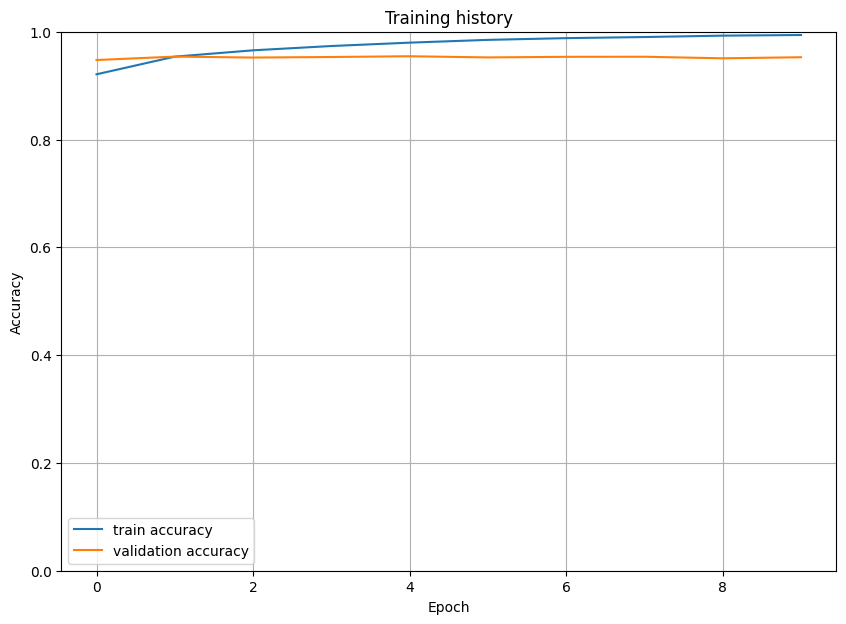

In [28]:
plt.rcParams["figure.figsize"] = (10,7)
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);
plt.grid()

## Evaluation of the model

In [29]:
# Loading pretrained model (best model)
model = BERTClass()
model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))
model = model.to(device)

/tmp/ipykernel_11129/4111296585.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(data_dir,"output","MLTC_model_state.bin")))

In [30]:
# Evaluate the model using the test data
test_acc, test_loss = eval_model(test_data_loader, model, optimizer)

In [31]:
# The accuracy looks OK, similar to the validation accuracy
# The model generalizes well !
test_acc

0.95325

In [32]:
from sklearn.metrics import confusion_matrix, classification_report   

In [33]:
def get_predictions(model, data_loader):
    """
    Outputs:
      predictions - 
    """
    model = model.eval()
    
    titles = []
    predictions = []
    prediction_probs = []
    target_values = []

    with torch.no_grad():
      for data in data_loader:
        title = data["title"]
        ids = data["input_ids"].to(device, dtype = torch.long)
        mask = data["attention_mask"].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data["targets"].to(device, dtype = torch.float)
        
        outputs = model(ids, mask, token_type_ids)
        # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
        outputs = torch.sigmoid(outputs).detach().cpu()
        # thresholding at 0.5
        preds = outputs.round()
        targets = targets.detach().cpu()

        titles.extend(title)
        predictions.extend(preds)
        prediction_probs.extend(outputs)
        target_values.extend(targets)
    
    predictions = torch.stack(predictions)
    prediction_probs = torch.stack(prediction_probs)
    target_values = torch.stack(target_values)
    
    return titles, predictions, prediction_probs, target_values


In [34]:
titles, predictions, prediction_probs, target_values = get_predictions(model, test_data_loader)

In [35]:
# sanity check
predictions.numpy()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

In [36]:
print(f"titles:{len(titles)} \npredictions:{predictions.shape} \nprediction_probs:{prediction_probs.shape} \ntarget_values:{target_values.shape}")

titles:1500 
predictions:torch.Size([1500, 8]) 
prediction_probs:torch.Size([1500, 8]) 
target_values:torch.Size([1500, 8])


In [37]:
# Generate Classification Metrics
#
# note that the total support is greater than the number of samples
# some samples have multiple lables

print(classification_report(target_values, predictions, target_names=target_list))

              precision    recall  f1-score   support

    astro-ph       0.92      0.90      0.91       213
    cond-mat       0.91      0.75      0.82       249
          cs       0.87      0.93      0.90       447
      hep-ph       0.81      0.86      0.83       111
      hep-th       0.78      0.56      0.66       110
        math       0.88      0.86      0.87       394
     physics       0.71      0.52      0.60       155
    quant-ph       0.71      0.81      0.76        80

   micro avg       0.86      0.82      0.84      1759
   macro avg       0.82      0.78      0.79      1759
weighted avg       0.85      0.82      0.83      1759
 samples avg       0.88      0.86      0.86      1759



/home/janani/Documents/pivony/ev/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Predicting on raw text

In [40]:
# raw text
raw_text = "Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC."

In [41]:
encoded_text = tokenizer.encode_plus(
    raw_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=True,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/janani/Documents/pivony/ev/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2870: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [42]:
input_ids = encoded_text['input_ids'].to(device)
attention_mask = encoded_text['attention_mask'].to(device)
token_type_ids = encoded_text['token_type_ids'].to(device)
output = model(input_ids, attention_mask, token_type_ids)
 # add sigmoid, for the training sigmoid is in BCEWithLogitsLoss
output = torch.sigmoid(output).detach().cpu()
# thresholding at 0.5
output = output.flatten().round().numpy()
output

array([0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [43]:
# Correctly identified the topic of the paper: High energy physics
print(f"Title: {raw_text}")
for idx, p in enumerate(output):
  if p==1:
    print(f"Label: {target_list[idx]}")

Title: Measurement of D-meson production as a function of charged-particle multiplicity in proton--proton collisions at s√=13 TeV with ALICE at the LHC.
Label: hep-ph
